MNIST


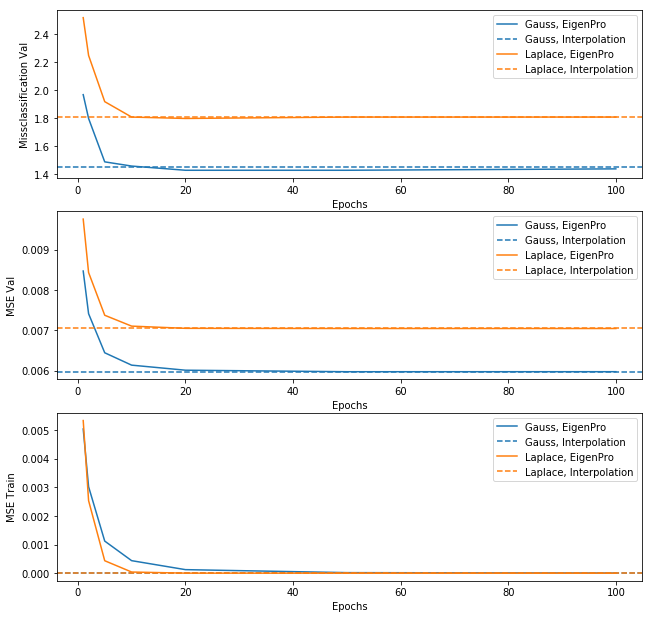

CIPHAR


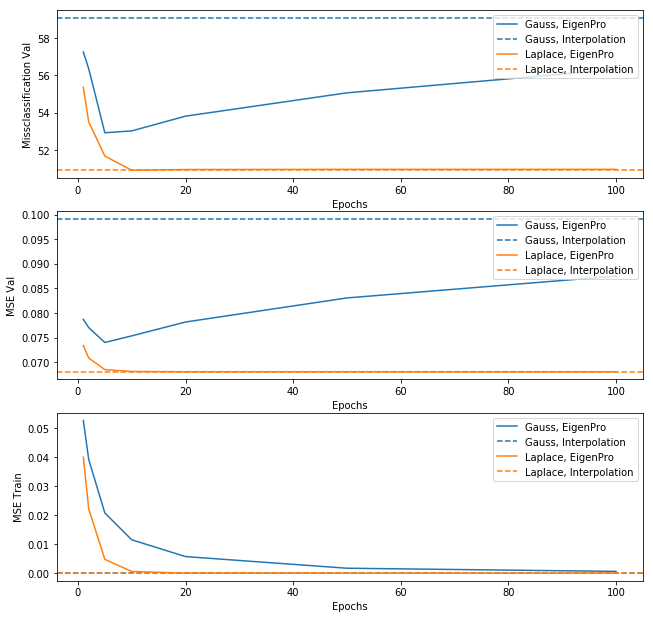

Synthetic1


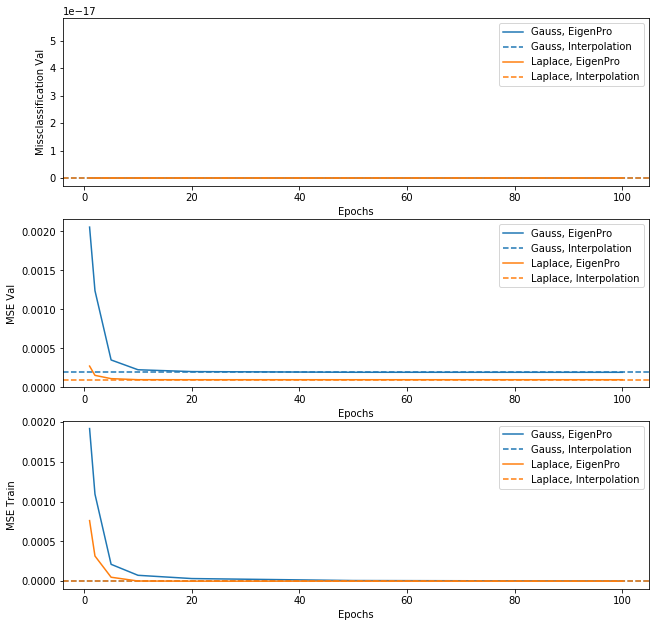

Synthetic2


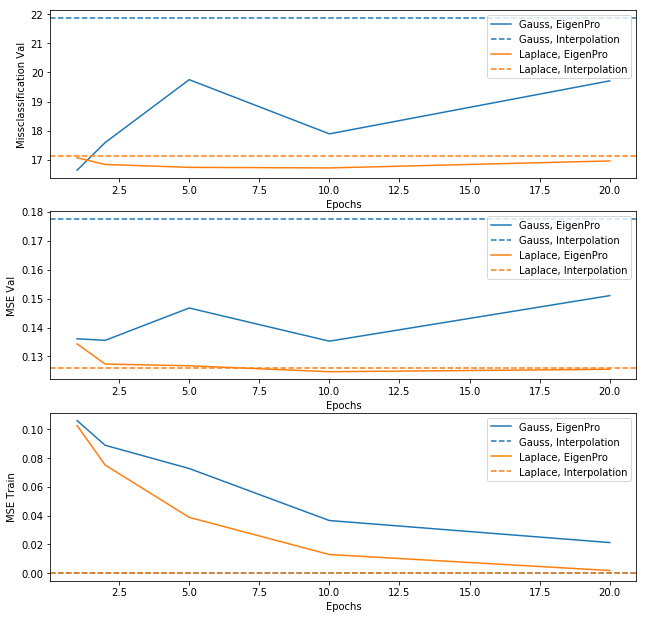

In [95]:

for dataset_name in ['MNIST', 'CIPHAR', 'Synthetic1', 'Synthetic2']:

    import glob
    files = glob.glob("../output/figure1" + dataset_name + "*.txt")
    files.sort()

    filename = files[-1]

    trainers_dict = eval(open(filename, 'r').read())
#     trainers_dict


    import matplotlib.pyplot as plt

    print(dataset_name)

    fig, axs = plt.subplots(3)
    ax = plt.gca()
    fig.set_size_inches(10.5, 10.5)

    for name, trainer in trainers_dict.items():  

        dic = trainer['te_scores']

        epoch = [x for x in dic.keys()]
        mse   = [x[0] for x in dic.values()]
        miss  = [(1 - x[1]) * 100 for x in dic.values()]

        color = next(ax._get_lines.prop_cycler)['color']
        axs[0].plot(epoch, miss, label=name + ', EigenPro', color=color)      
        axs[0].axhline(y=trainer['lin_test_ce'] * 100, label=name + ', Interpolation', linestyle='--', color=color)

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Missclassification Val')
    axs[0].legend(loc='upper right')

    ax.set_prop_cycle(None)

    for name, trainer in trainers_dict.items():  

        dic = trainer['te_scores']

        epoch = [x for x in dic.keys()]
        mse   = [x[0] for x in dic.values()]
        miss  = [x[1] for x in dic.values()]

        color = next(ax._get_lines.prop_cycler)['color']
        axs[1].plot(epoch, mse, label=name + ', EigenPro', color=color) 
        axs[1].axhline(y=trainer['lin_test_mse'], label=name + ', Interpolation', linestyle='--', color=color)

    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MSE Val')
    axs[1].legend(loc='upper right')

    ax.set_prop_cycle(None)

    for name, trainer in trainers_dict.items():  

        dic = trainer['tr_scores']

        epoch = [x for x in dic.keys()]
        mse   = [x[0] for x in dic.values()]
        miss  = [x[1] for x in dic.values()]

        color = next(ax._get_lines.prop_cycler)['color']
        axs[2].plot(epoch, mse, label=name + ', EigenPro', color=color) 
        axs[2].axhline(y=trainer['lin_train_mse'], label=name + ', Interpolation', linestyle='--', color=color)

    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('MSE Train')
    axs[2].legend(loc='upper right')

    import matplotlib2tikz
    filename = '../tikz/Figure1_' + dataset_name + '.tex'
    matplotlib2tikz.save(filename)    

    filename = '../png/Figure1_' + dataset_name + '.png'
    plt.savefig(filename)
    plt.show()


In [ ]:
#del trainers_dict